# Configurações

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox
from sklearn.model_selection import ParameterGrid
from pmdarima import auto_arima, model_selection
from pmdarima import ARIMA as ARIMA2

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Emprego/AGIBANK/SELIC_IPCA_DOLAR2.csv")
data.head()

,mes,mes_original,selic,ipca,dolar
0,01/01/00,jan/00,19.0,8.85,1.82
1,01/02/00,fev/00,19.0,7.86,1.78
2,01/03/00,mar/00,18.5,6.92,1.74
3,01/04/00,abr/00,18.5,6.77,1.78
4,01/05/00,mai/00,18.5,6.47,1.83


In [4]:
data.mes = pd.to_datetime(data.mes,format='%d/%m/%y' )

In [90]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')

  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  mse = mean_squared_error(test, predictions)  # MSE padrão
  rmse = mse ** 0.5  # Para obter o RMSE (root mean squared error)
  #rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [91]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

#Exploração de dados

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   mes           300 non-null    datetime64[ns]
 1   mes_original  300 non-null    object        
 2   selic         300 non-null    float64       
 3   ipca          300 non-null    float64       
 4   dolar         300 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 11.8+ KB


In [8]:
data.head(300)

,mes,mes_original,selic,ipca,dolar
0,2000-01-01,jan/00,19.00,8.85,1.82
1,2000-02-01,fev/00,19.00,7.86,1.78
2,2000-03-01,mar/00,18.50,6.92,1.74
3,2000-04-01,abr/00,18.50,6.77,1.78
4,2000-05-01,mai/00,18.50,6.47,1.83
...,...,...,...,...,...
295,2024-08-01,ago/24,10.50,4.24,5.58
296,2024-09-01,set/24,10.75,4.42,5.54
297,2024-10-01,out/24,10.75,4.76,5.61
298,2024-11-01,Nov/24,11.25,4.87,5.85


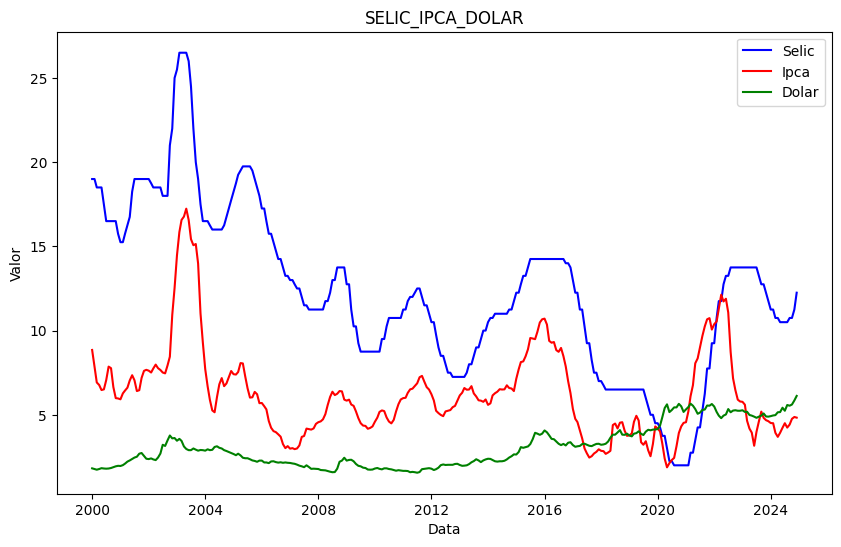

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(data.mes, data.selic, color='blue',label='Selic')
plt.plot(data.mes, data.ipca, color='red', label='Ipca')
plt.plot(data.mes, data.dolar, color='green', label='Dolar')
plt.title('SELIC_IPCA_DOLAR')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

<Axes: >

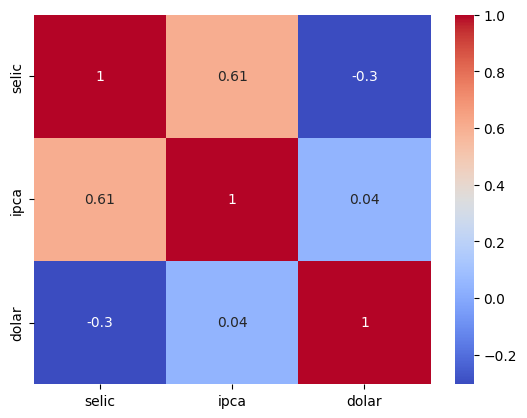

In [10]:
sns.heatmap(data[["selic", "ipca", "dolar"]].corr(), annot=True, cmap='coolwarm')

<ipython-input-11-0d2ec6e020e2>:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(data2.selic.resample('Q').mean(), ylabel='Selic Quarter')


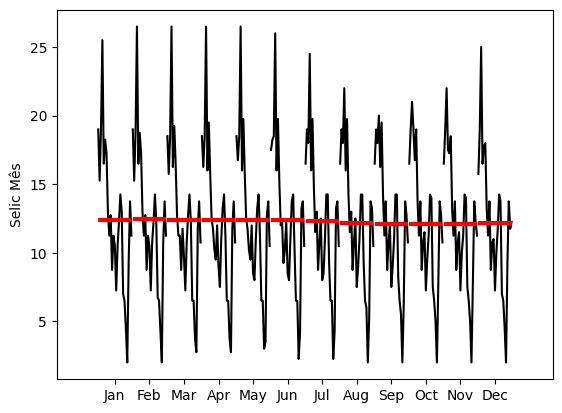

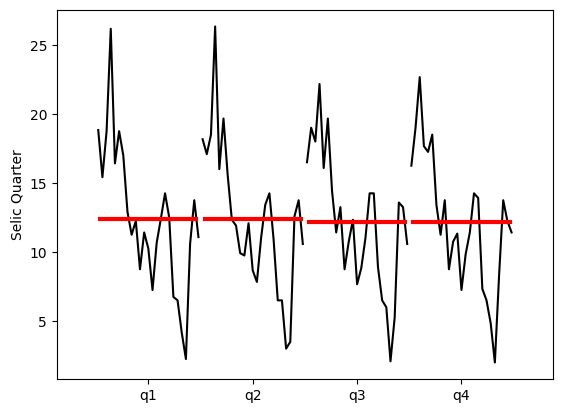

In [11]:
data2 = data.set_index('mes')
month_plot(data2.selic.resample('ME').mean(), ylabel = 'Selic Mês')
quarter_plot(data2.selic.resample('Q').mean(), ylabel='Selic Quarter')
plt.show()

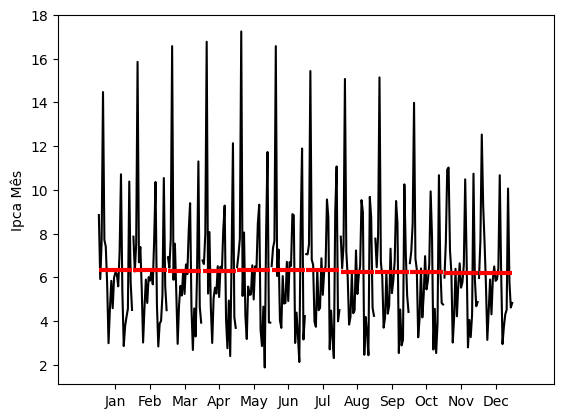

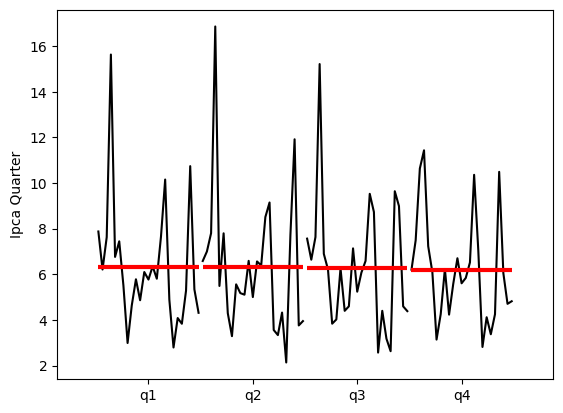

In [12]:
month_plot(data2.ipca.resample('ME').mean(), ylabel = 'Ipca Mês')
quarter_plot(data2.ipca.resample('QE').mean(), ylabel='Ipca Quarter')
plt.show()

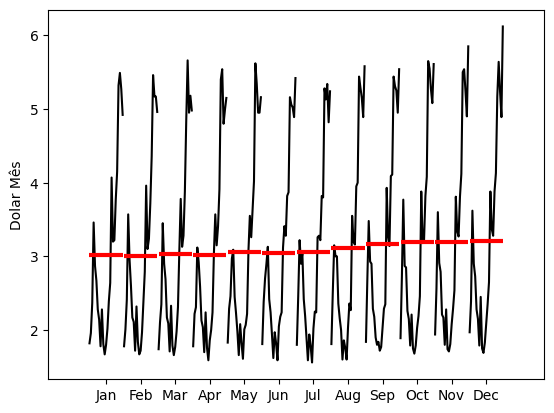

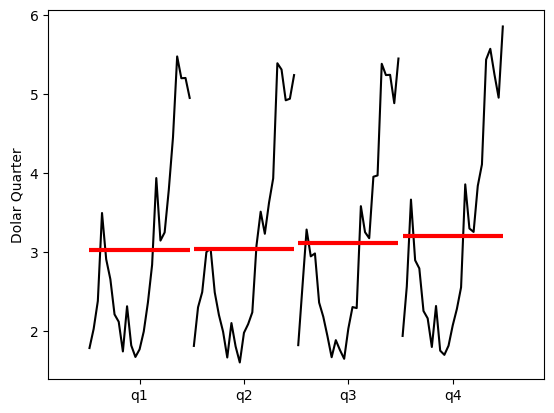

In [13]:
month_plot(data2.dolar.resample('ME').mean(), ylabel = 'Dolar Mês')
quarter_plot(data2.dolar.resample('QE').mean(), ylabel='Dolar Quarter')
plt.show()

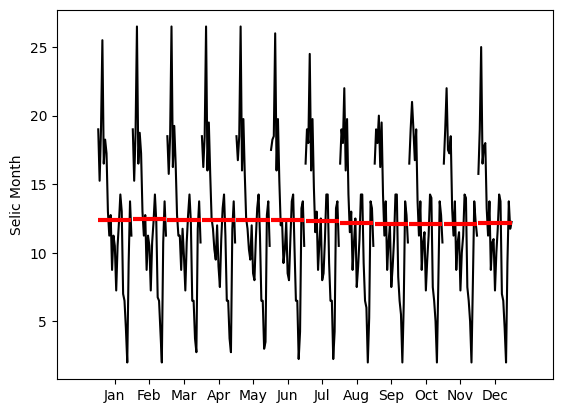

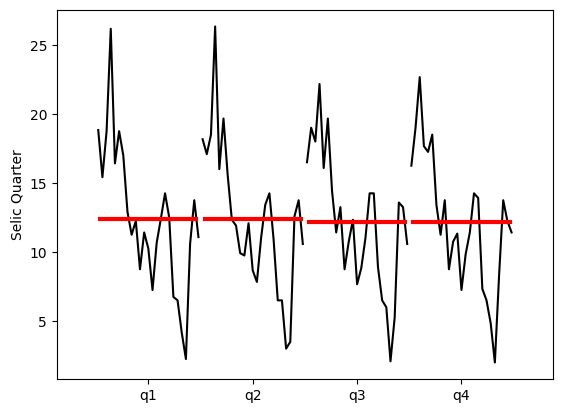

In [14]:
# Instead of resampling to 'YE' (Year End), resample to 'M' (Month) or 'Q' (Quarter)
# For Monthly plot:
month_plot(data2.selic.resample('ME').mean(), ylabel='Selic Month')
plt.show()

# For Quarterly plot, use the `quarter_plot` function:
quarter_plot(data2.selic.resample('QE').mean(), ylabel='Selic Quarter')
plt.show()

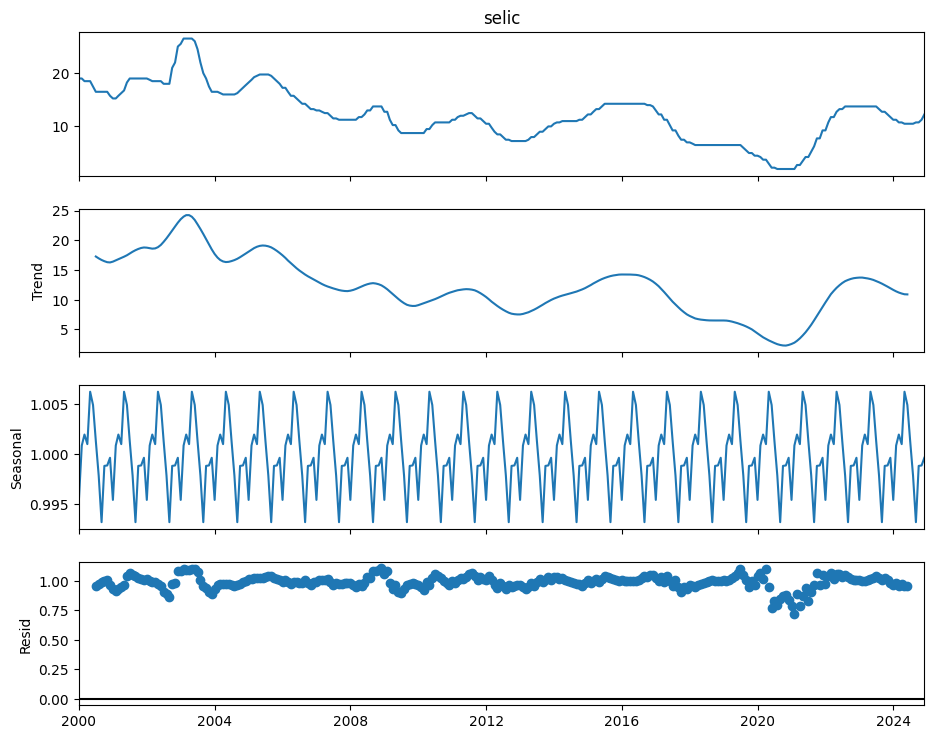

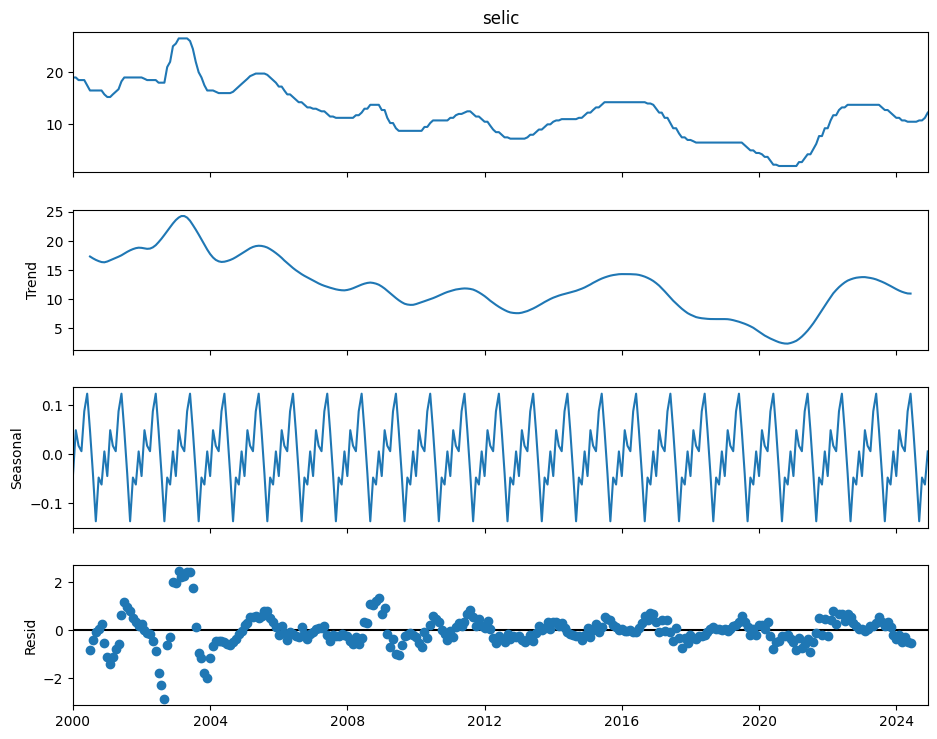

In [15]:
decomposition = seasonal_decompose(data2['selic'],model = 'mul', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

decomposition = seasonal_decompose(data2['selic'],model = 'add', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

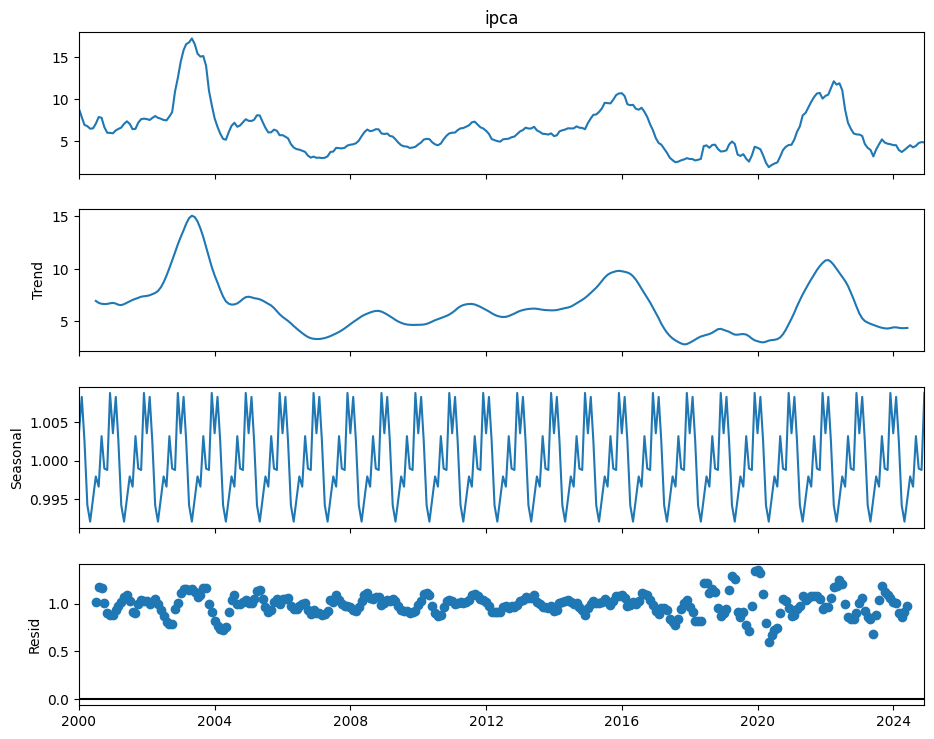

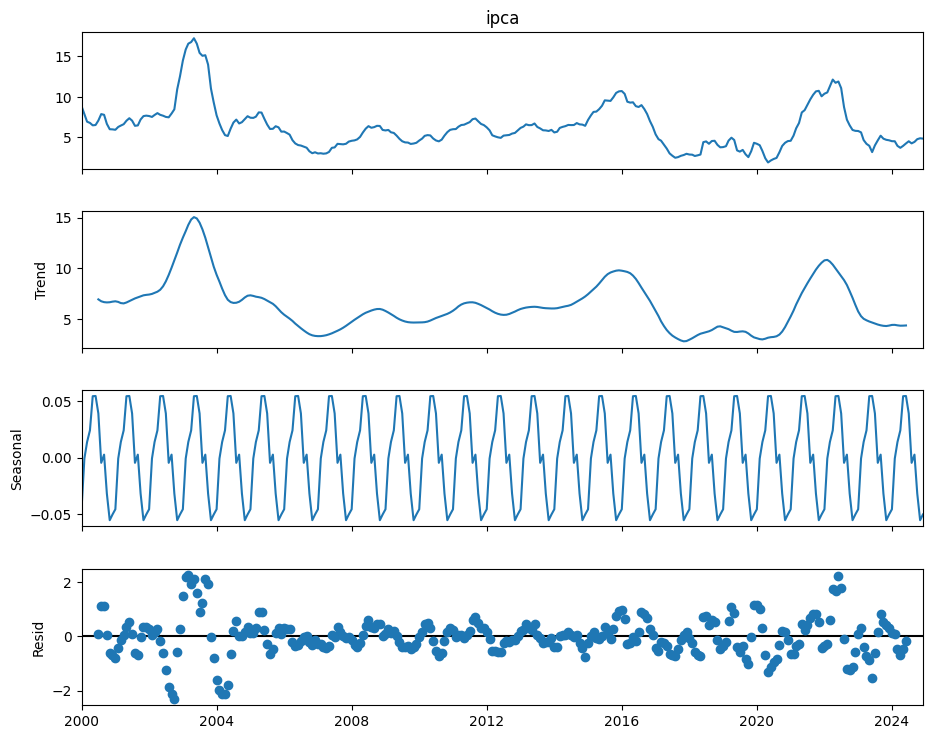

In [16]:
decomposition = seasonal_decompose(data2['ipca'],model = 'mul', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

decomposition = seasonal_decompose(data2['ipca'],model = 'add', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

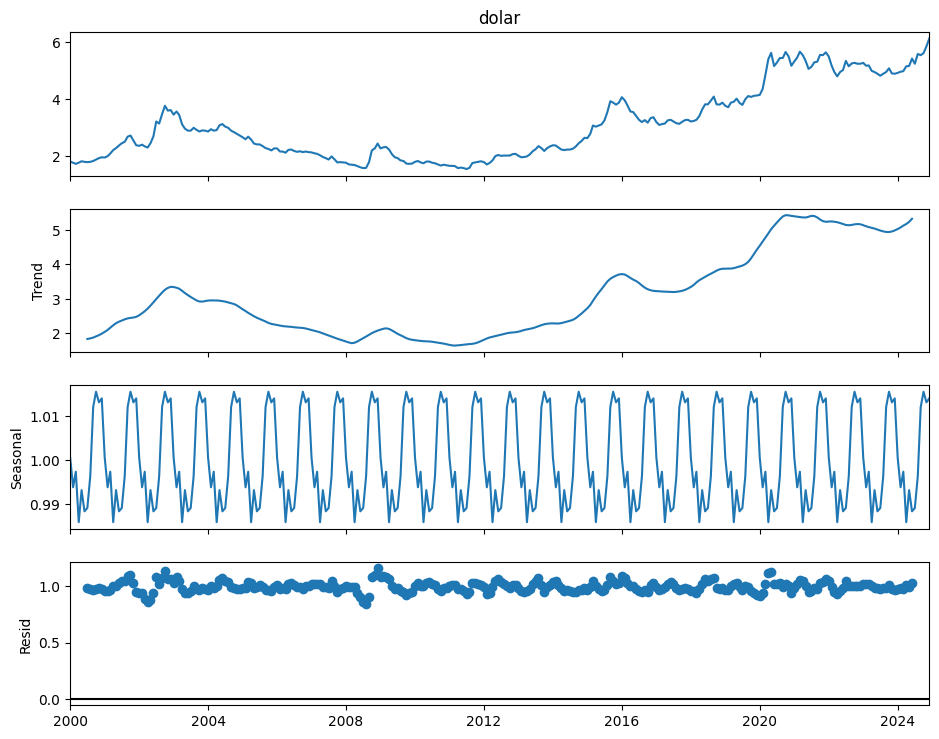

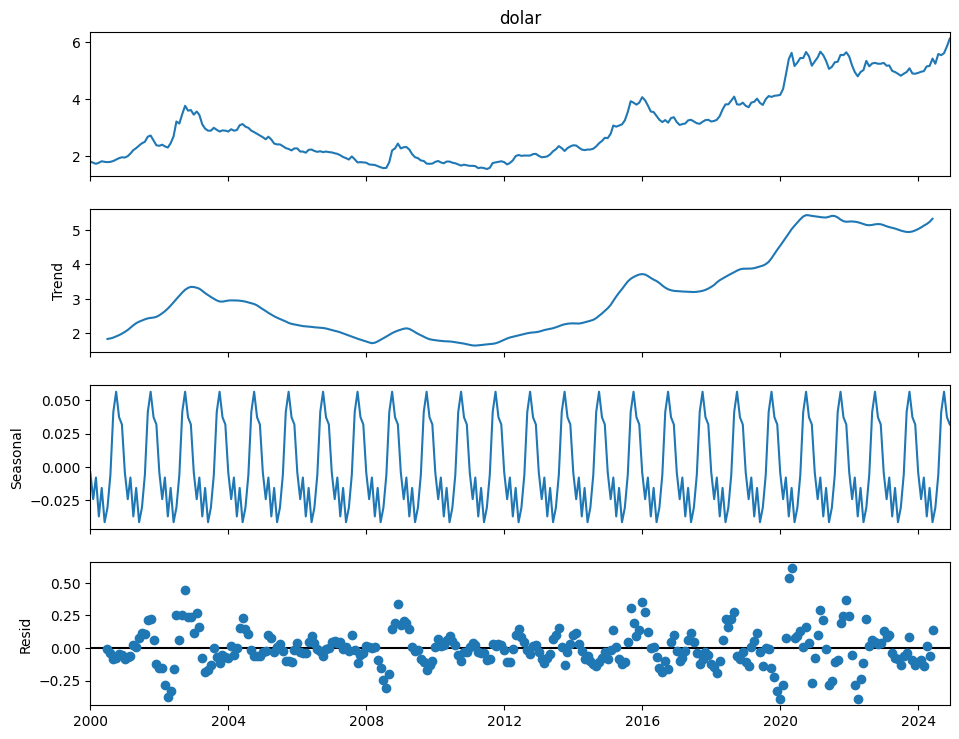

In [17]:
decomposition = seasonal_decompose(data2['dolar'],model = 'mul', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

decomposition = seasonal_decompose(data2['dolar'],model = 'add', period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

#ACF e PACF

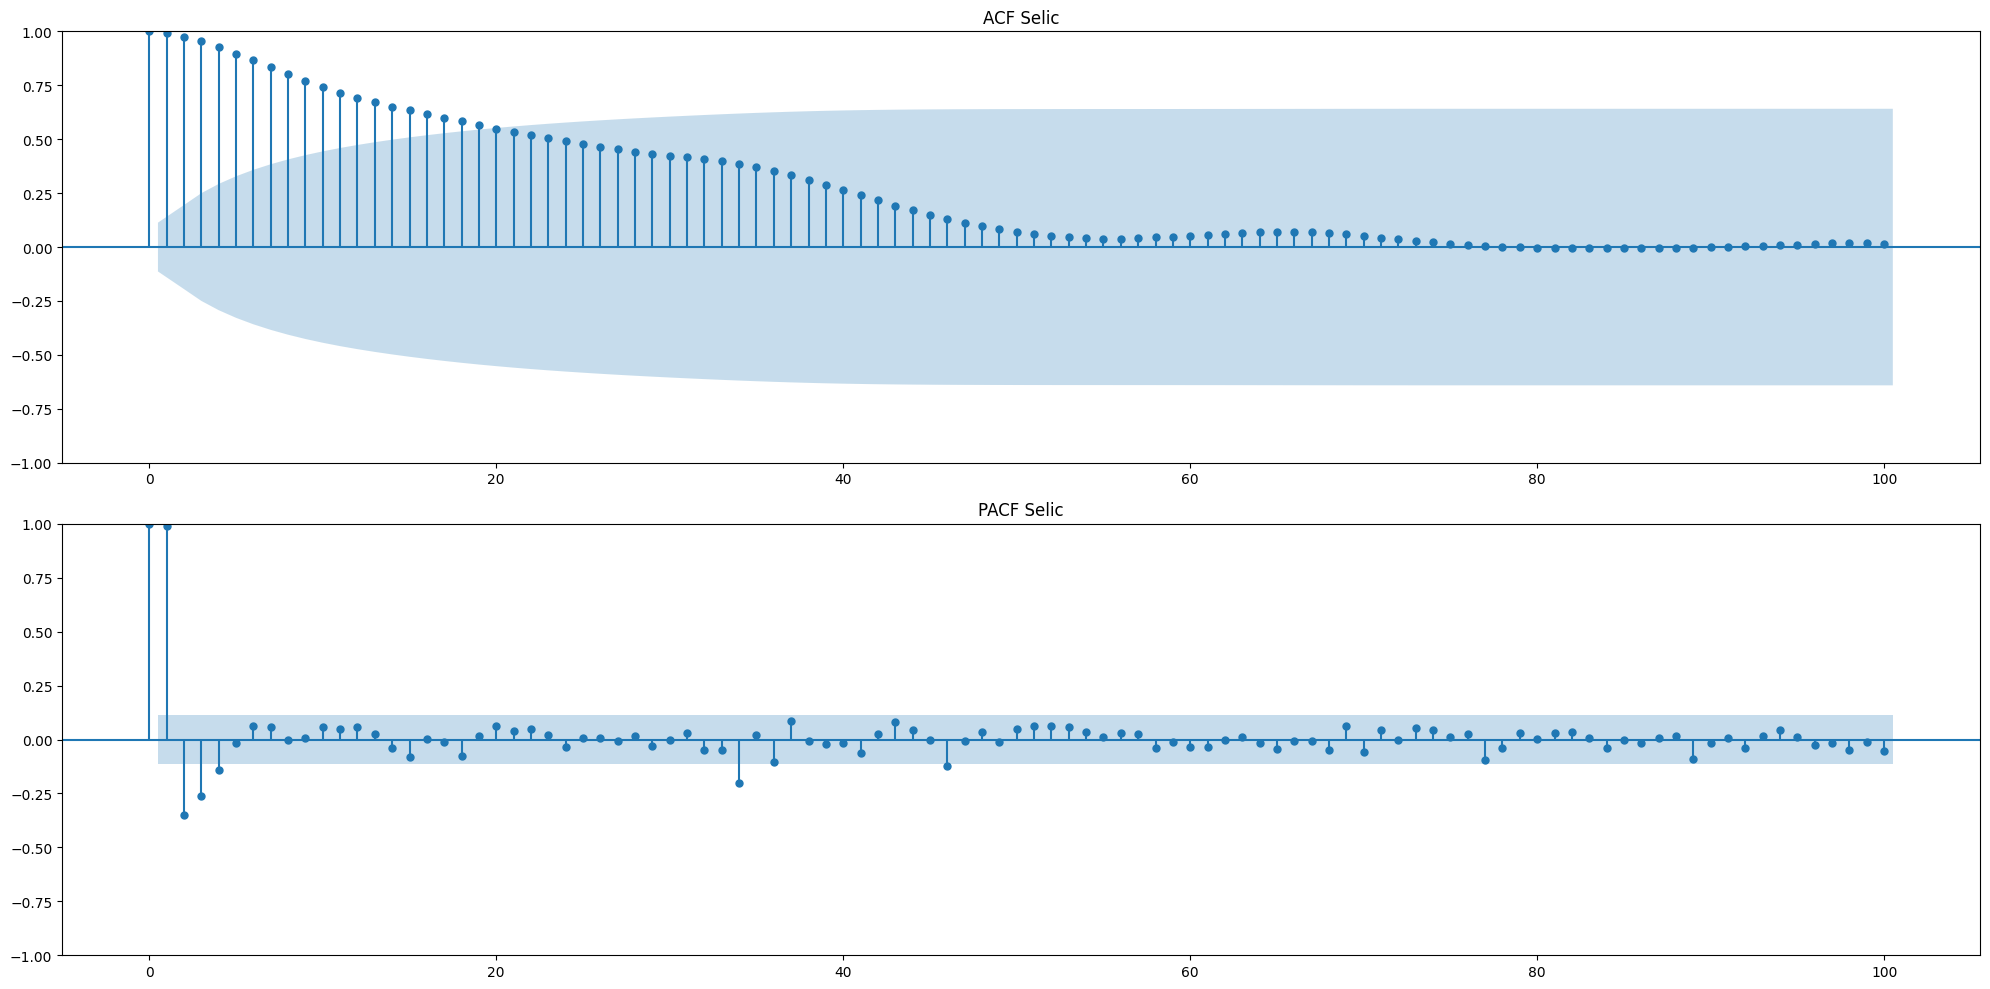

In [18]:

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['selic'], lags=100, ax=axes[0])
axes[0].set_title('ACF Selic')

plot_pacf(data2['selic'], lags=100, ax=axes[1])
axes[1].set_title('PACF Selic')

plt.tight_layout()
plt.show()

Aparentemente são relevante os lags 2,3,4,5, 34 e 46 no PACF

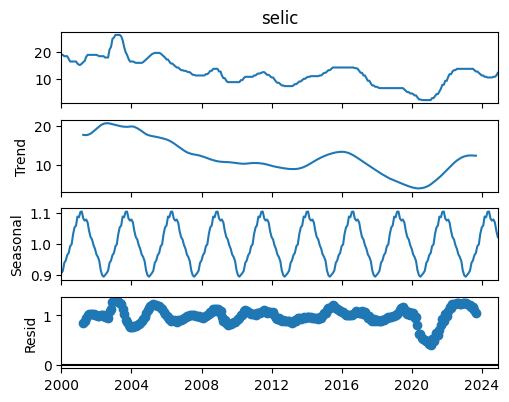

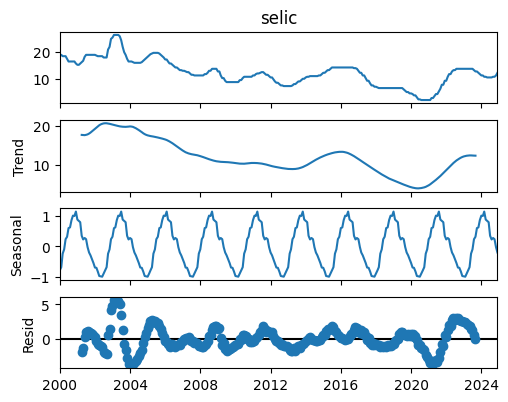

In [19]:
decomposition = seasonal_decompose(data2['selic'],model = 'mul', period =31)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

decomposition = seasonal_decompose(data2['selic'],model = 'add', period =31)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

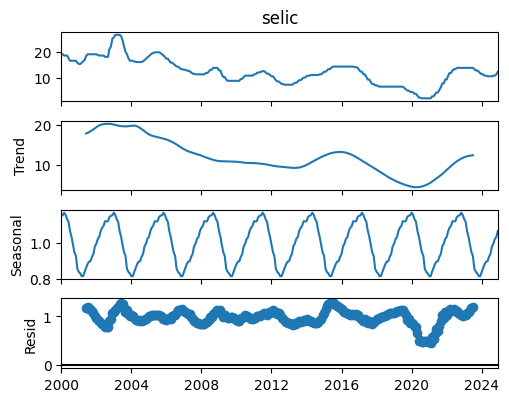

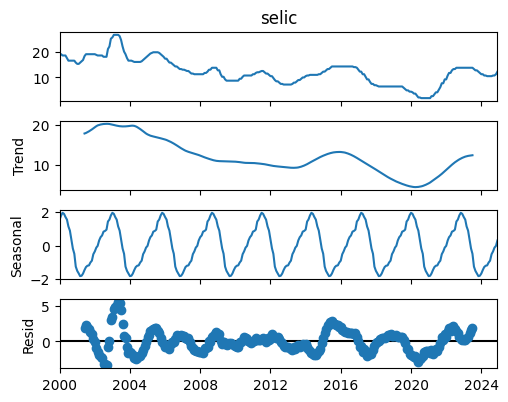

In [20]:
decomposition = seasonal_decompose(data2['selic'],model = 'mul', period =34)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

decomposition = seasonal_decompose(data2['selic'],model = 'add', period =34)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

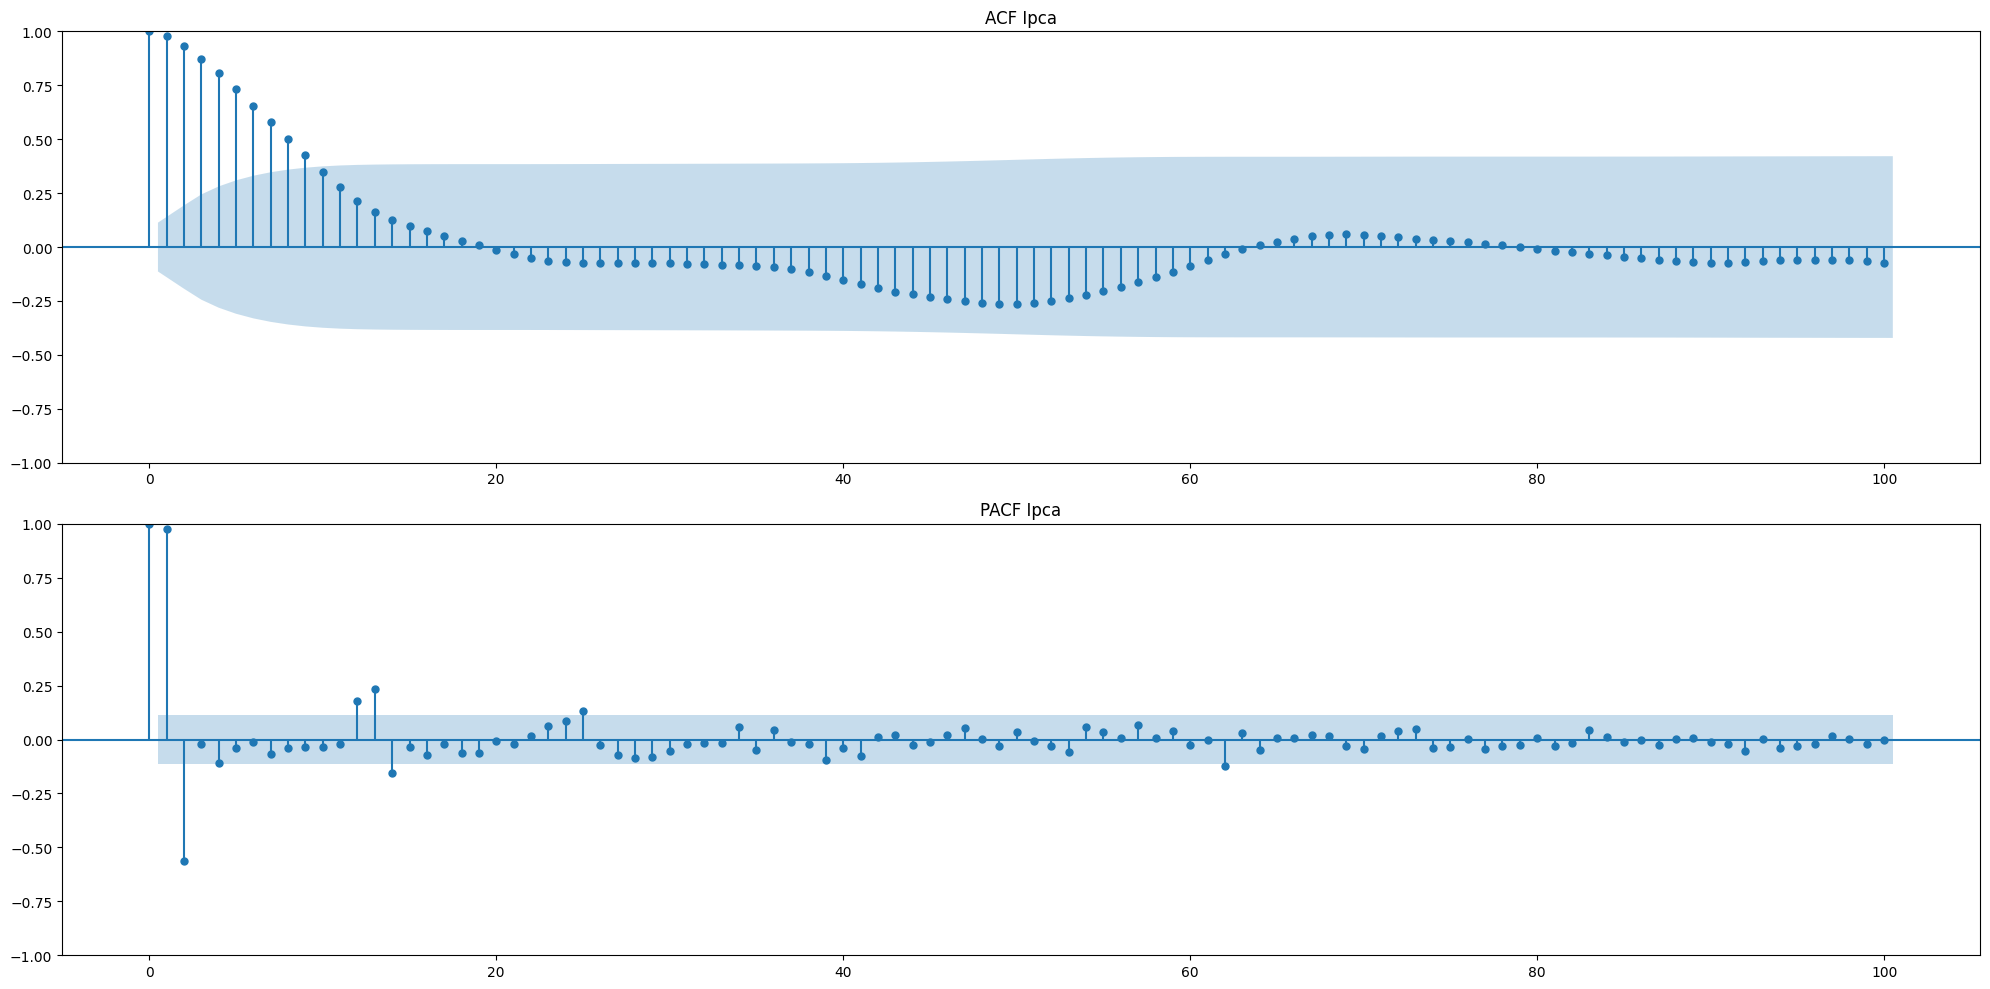

In [21]:

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['ipca'], lags=100, ax=axes[0])
axes[0].set_title('ACF Ipca')

plot_pacf(data2['ipca'], lags=100, ax=axes[1])
axes[1].set_title('PACF Ipca')

plt.tight_layout()
plt.show()

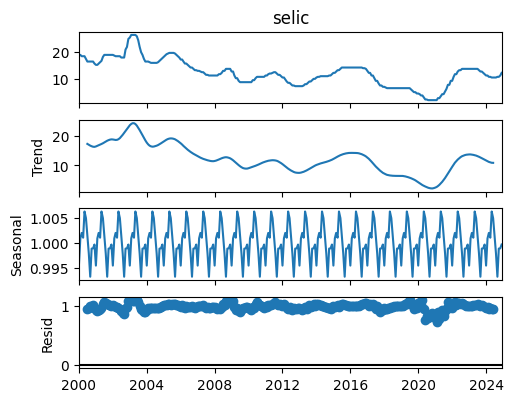

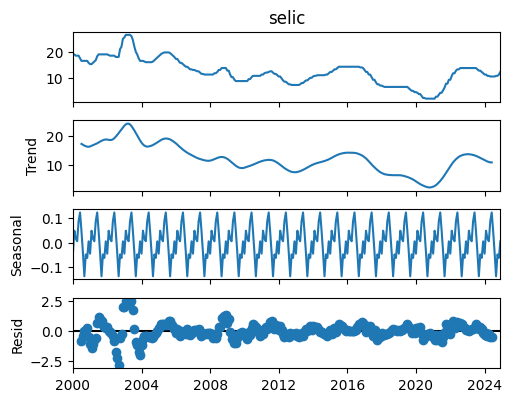

In [22]:
decomposition = seasonal_decompose(data2['selic'],model = 'mul', period =12)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

decomposition = seasonal_decompose(data2['selic'],model = 'add', period =12)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

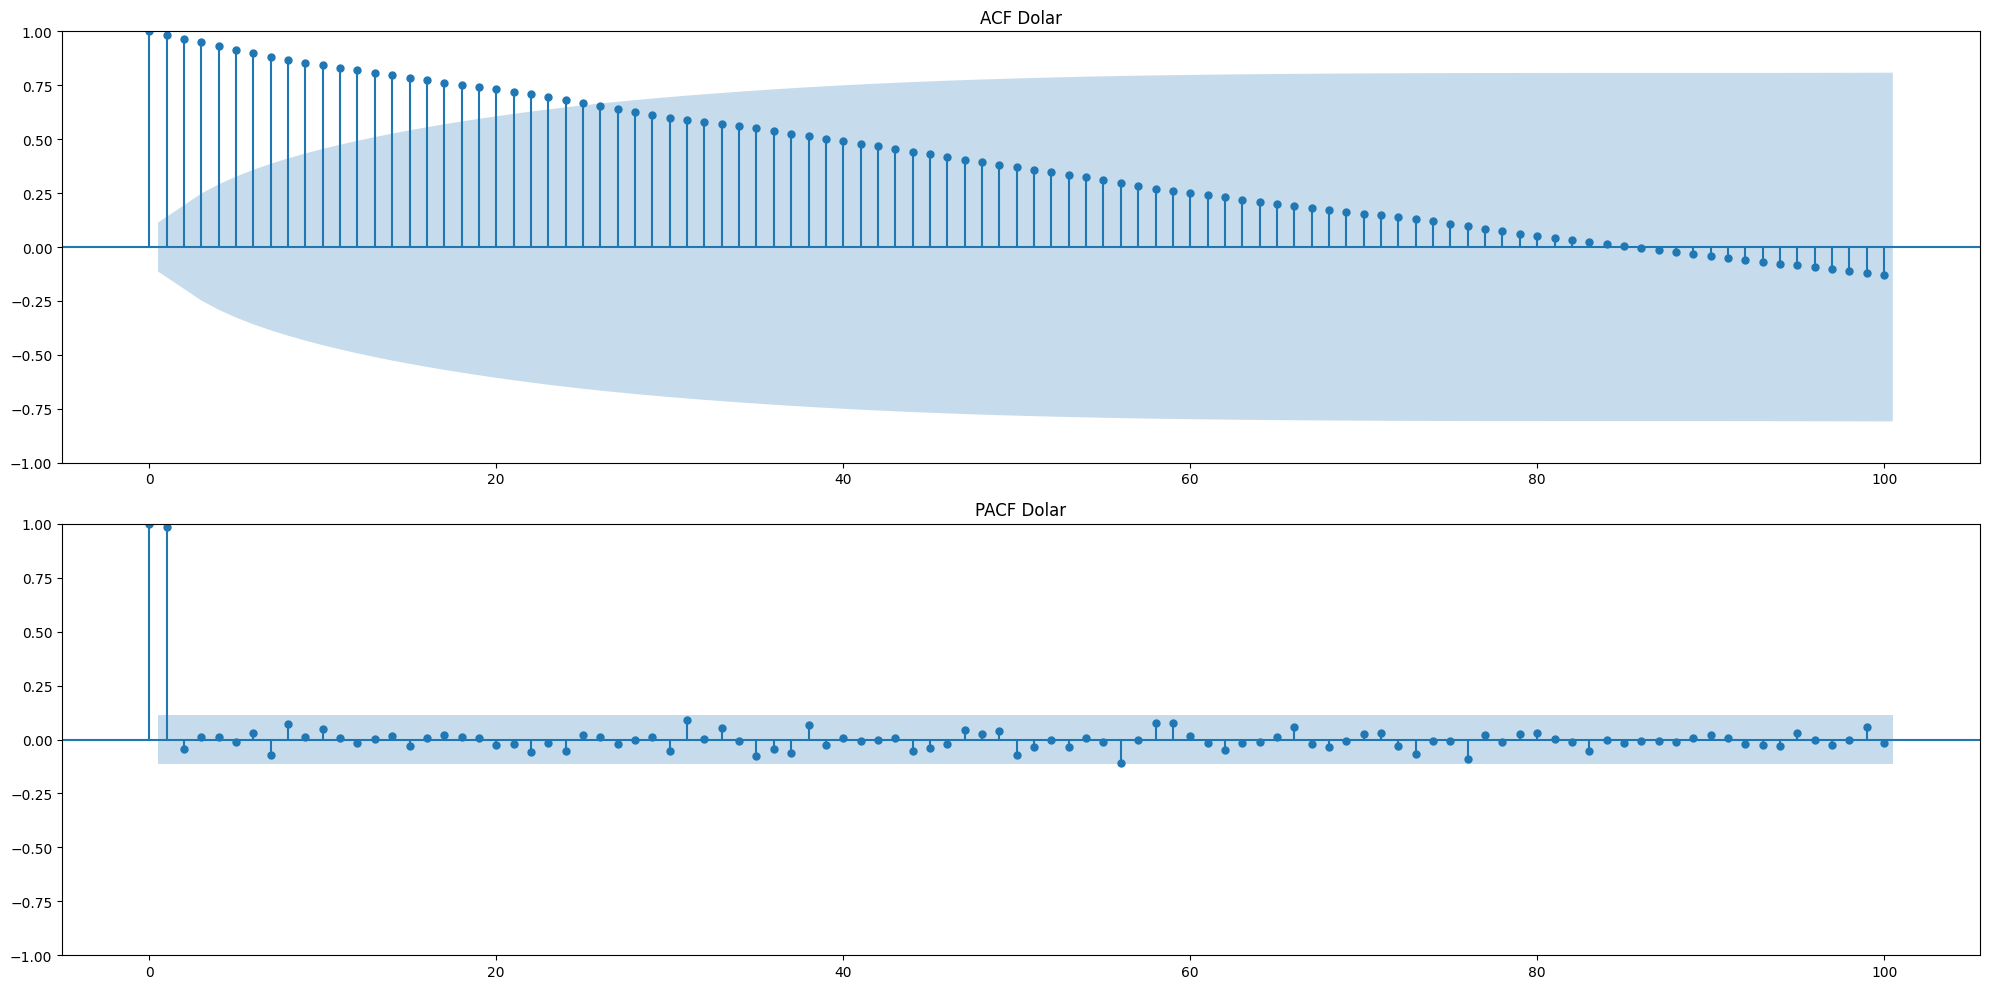

In [23]:

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['dolar'], lags=100, ax=axes[0])
axes[0].set_title('ACF Dolar')

plot_pacf(data2['dolar'], lags=100, ax=axes[1])
axes[1].set_title('PACF Dolar')

plt.tight_layout()
plt.show()

Dolar aparentemente tem menos sesonality sendo menos previsível

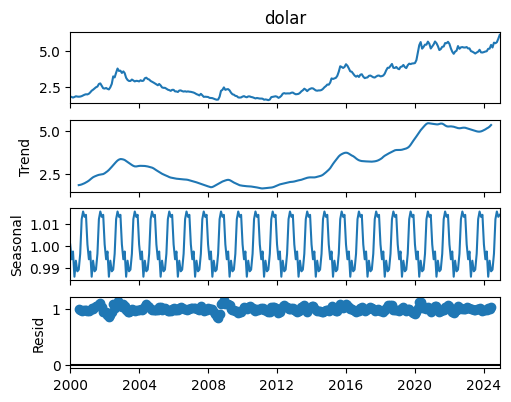

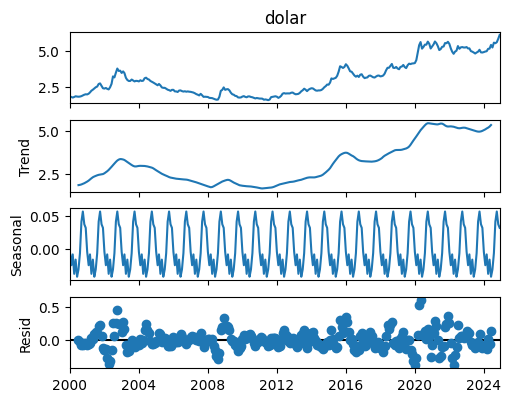

In [24]:
decomposition = seasonal_decompose(data2['dolar'],model = 'mul', period =12)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

decomposition = seasonal_decompose(data2['dolar'],model = 'add', period =12)
fig = decomposition.plot()
fig.set_size_inches(5,4)
plt.show()

#Stationary

p-value selic: 0.177664
Evidence suggests that the time series is not stationary.
p-value ipca: 0.048710
Evidence suggests that the time series is stationary.
p-value dolar: 0.953847
Evidence suggests that the time series is not stationary.


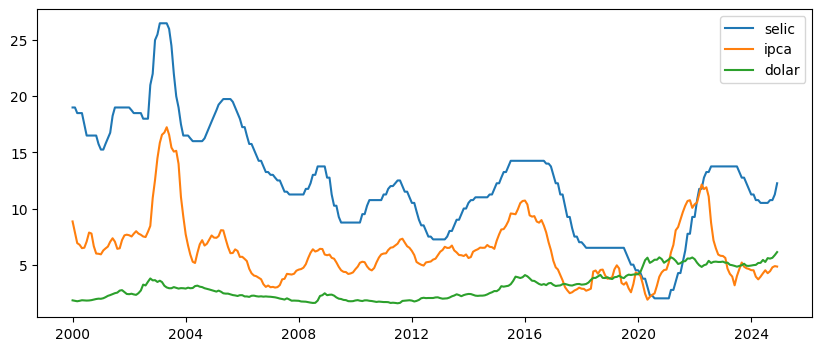

In [25]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(data2.selic)
print('p-value selic: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

result = adfuller(data2.ipca)
print('p-value ipca: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

result = adfuller(data2.dolar)
print('p-value dolar: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

plt.figure(figsize = (10,4))
plt.plot(data2['selic'], label = 'selic')
plt.plot(data2['ipca'], label = 'ipca')
plt.plot(data2['dolar'], label = 'dolar')
plt.legend()
plt.show()

p-value selic_diff: 0.000005
Evidence suggests that the time series is stationary.
p-value ipca_diff: 0.000001
Evidence suggests that the time series is stationary.
p-value dolar_diff: 0.000000
Evidence suggests that the time series is stationary.


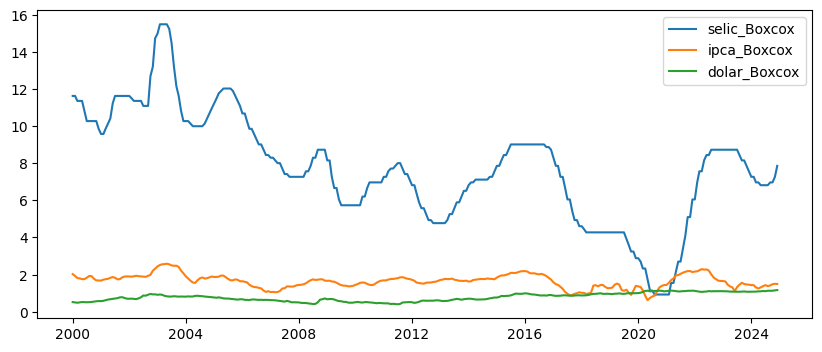

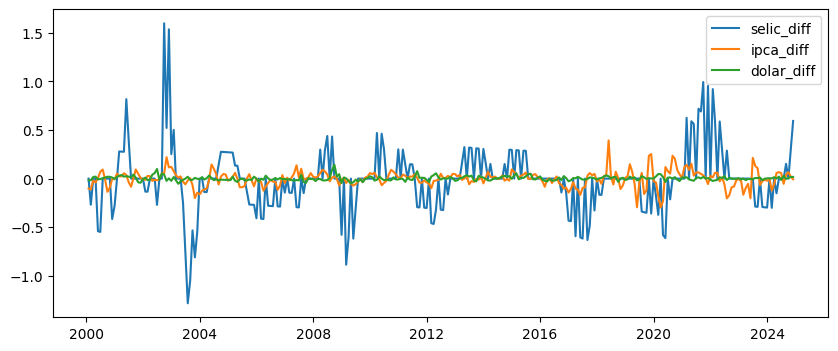

In [26]:
data2['selic_Boxcox'], lam_selic = boxcox(data2['selic'])
data2['ipca_Boxcox'], lam_ipca = boxcox(data2['ipca'])
data2['dolar_Boxcox'], lam_dolar = boxcox(data2['dolar'])

data2['selic_diff'] = data2['selic_Boxcox'].diff().dropna()
data2['ipca_diff'] = data2['ipca_Boxcox'].diff().dropna()
data2['dolar_diff'] = data2['dolar_Boxcox'].diff().dropna()

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(data2.selic_diff.dropna())
print('p-value selic_diff: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

result = adfuller(data2.ipca_diff.dropna())
print('p-value ipca_diff: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

result = adfuller(data2.dolar_diff.dropna())
print('p-value dolar_diff: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

plt.figure(figsize = (10,4))
plt.plot(data2['selic_Boxcox'], label = 'selic_Boxcox')
plt.plot(data2['ipca_Boxcox'], label = 'ipca_Boxcox')
plt.plot(data2['dolar_Boxcox'], label = 'dolar_Boxcox')
plt.legend()
plt.show()

plt.figure(figsize = (10,4))
plt.plot(data2['selic_diff'], label = 'selic_diff')
plt.plot(data2['ipca_diff'], label = 'ipca_diff')
plt.plot(data2['dolar_diff'], label = 'dolar_diff')
plt.legend()
plt.show()

#  ACF e PACF (Stationary)




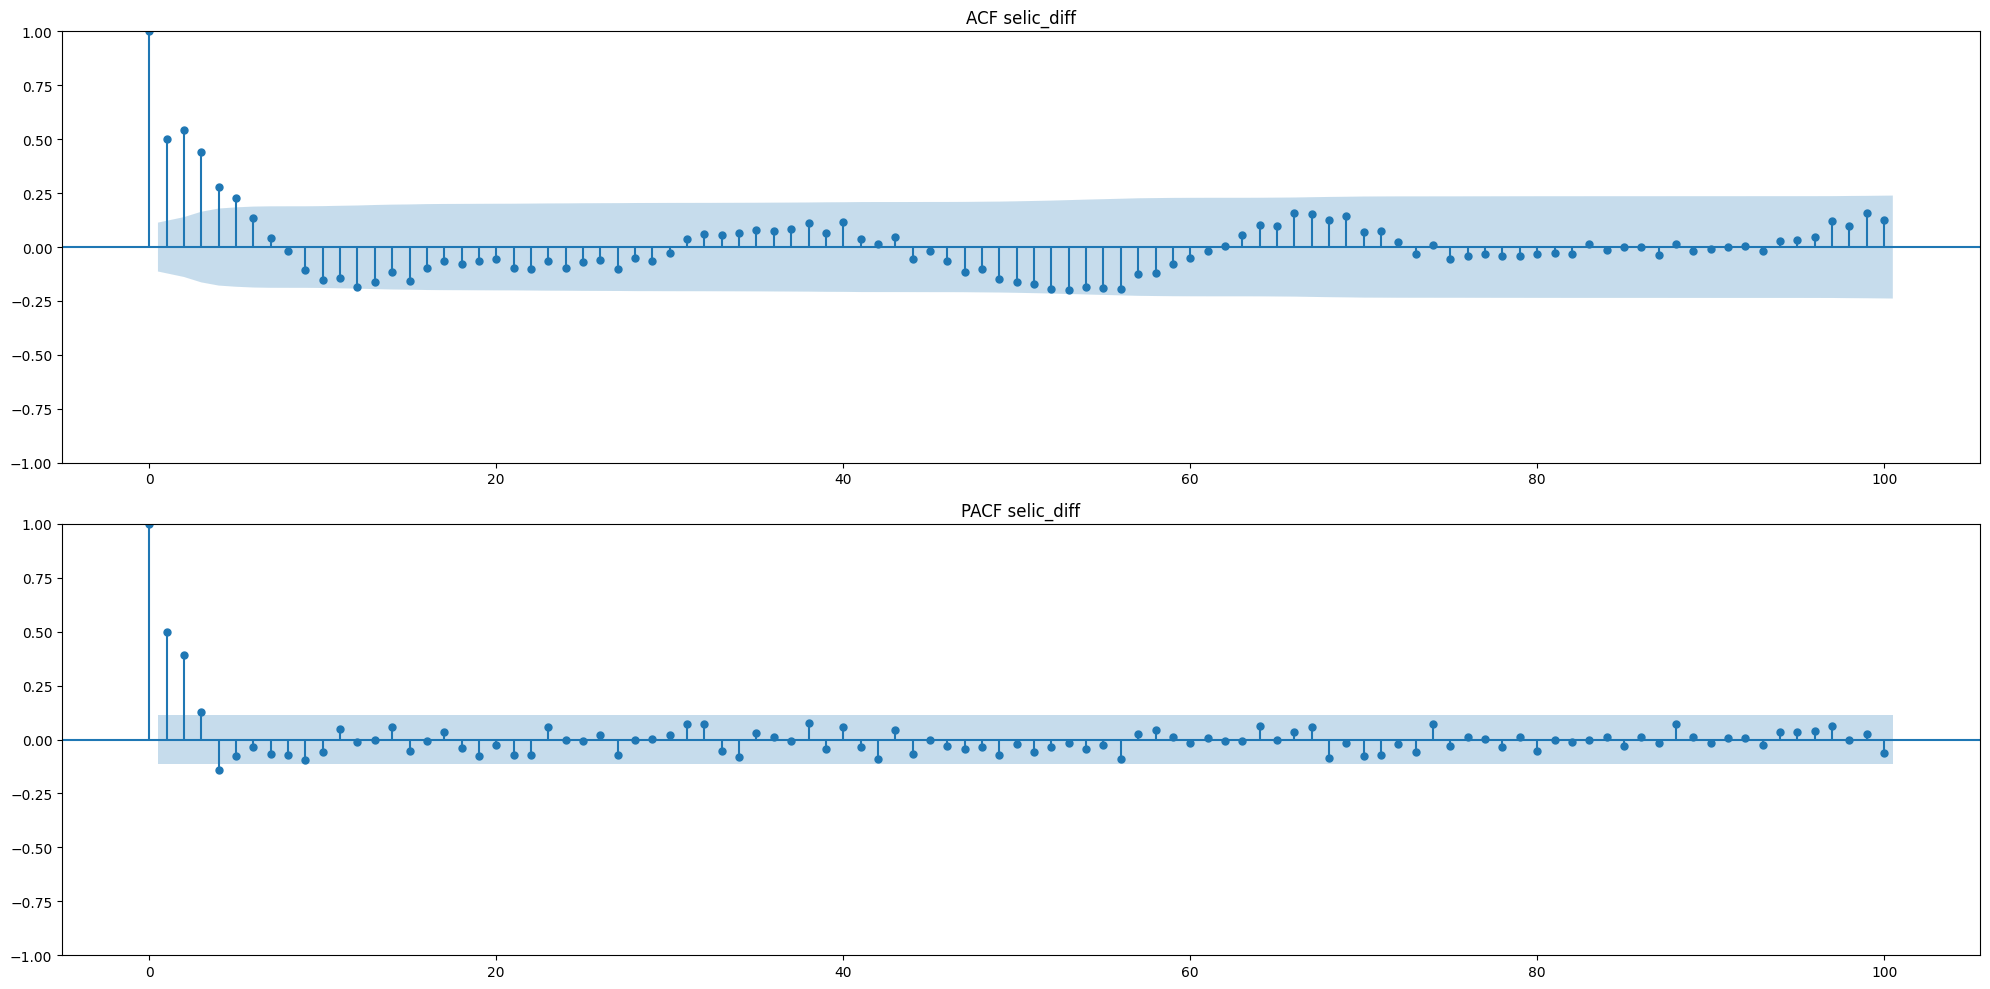

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['selic_diff'].dropna(), lags=100, ax=axes[0])
axes[0].set_title('ACF selic_diff')

plot_pacf(data2['selic_diff'].dropna(), lags=100, ax=axes[1])
axes[1].set_title('PACF selic_diff')

plt.tight_layout()
plt.show()

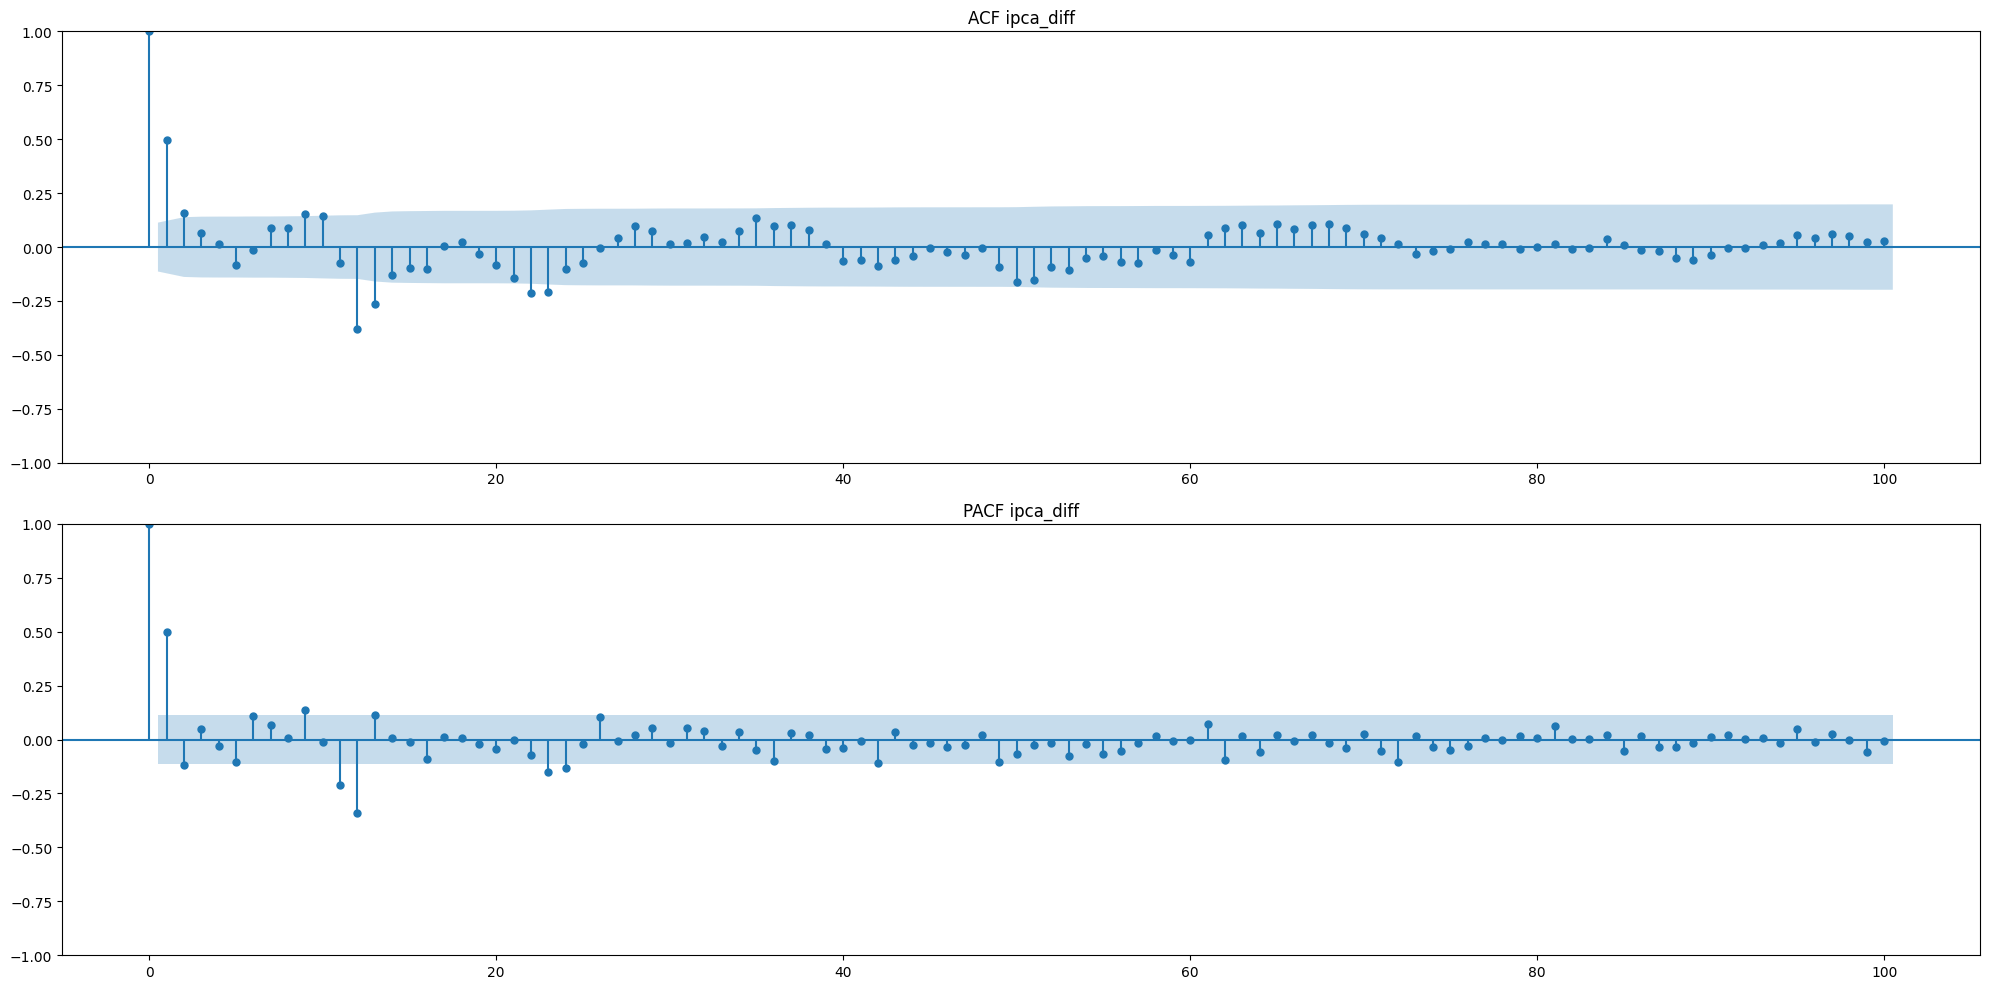

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['ipca_diff'].dropna(), lags=100, ax=axes[0])
axes[0].set_title('ACF ipca_diff')

plot_pacf(data2['ipca_diff'].dropna(), lags=100, ax=axes[1])
axes[1].set_title('PACF ipca_diff')

plt.tight_layout()
plt.show()

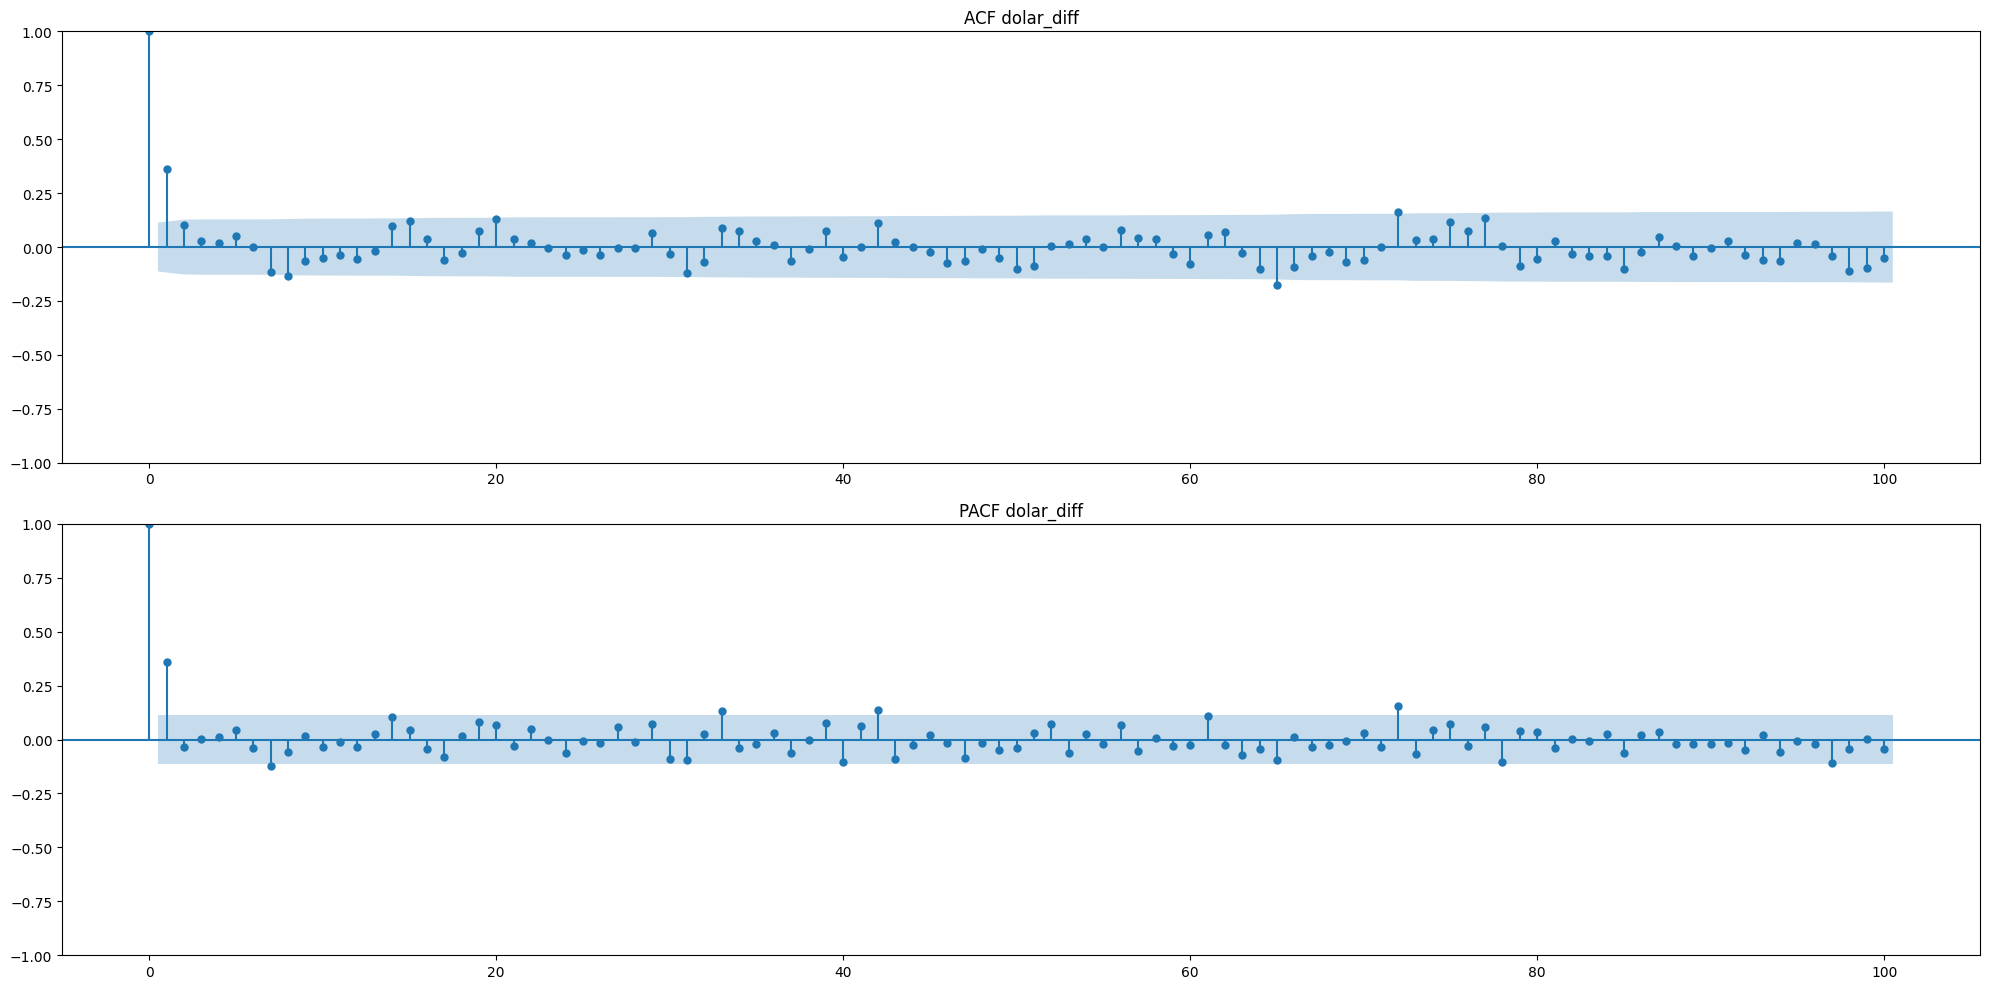

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plot_acf(data2['dolar_diff'].dropna(), lags=100, ax=axes[0])
axes[0].set_title('ACF dolar_diff')

plot_pacf(data2['dolar_diff'].dropna(), lags=100, ax=axes[1])
axes[1].set_title('PACF dolar_diff')

plt.tight_layout()
plt.show()

# Split Train/Test


In [30]:
'''split = int((data2.selic.dropna().count())/5)
train_selic, test_selic = data2.selic.dropna().iloc[split:], data2.selic.dropna().iloc[:split]

split = int((data2.ipca.dropna().count())/5)
train_ipca, test_ipca = data2.ipca.dropna().iloc[split:], data2.ipca.dropna().iloc[:split]

split = int((data2.dolar_diff.dropna().count())/5)
train_dolar, test_dolar = data2.dolar.dropna().iloc[split:], data2.dolar.dropna().iloc[:split]
'''

'''split = int((data2.selic.dropna().count())/5)
train, test = data2.dropna().iloc[split:], data2.dropna().iloc[:split]'''

split = int((data2.selic.dropna().count())/15)
train, test = data2.dropna().iloc[:-split], data2.dropna().iloc[-split:]

'''ou usar o seguinte código
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]'''


'ou usar o seguinte código\ntrain = data.iloc[:-int(len(data) * 0.2)]\ntest = data.iloc[-int(len(data) * 0.2):]'

In [31]:
test.count()

,0
mes_original,20
selic,20
ipca,20
dolar,20
selic_Boxcox,20
ipca_Boxcox,20
dolar_Boxcox,20
selic_diff,20
ipca_diff,20
dolar_diff,20


In [32]:
train

,mes_original,selic,ipca,dolar,selic_Boxcox,ipca_Boxcox,dolar_Boxcox,selic_diff,ipca_diff,dolar_diff
mes,,,,,,,,,,
2000-02-01,fev/00,19.00,7.86,1.78,11.635643,1.921552,0.496523,0.000000,-0.102447,-0.016253
2000-03-01,mar/00,18.50,6.92,1.74,11.367436,1.810618,0.479700,-0.268208,-0.110934,-0.016823
2000-04-01,abr/00,18.50,6.77,1.78,11.367436,1.791432,0.496523,0.000000,-0.019185,0.016823
2000-05-01,mai/00,18.50,6.47,1.83,11.367436,1.751660,0.516754,0.000000,-0.039773,0.020231
2000-06-01,jun/00,17.50,6.51,1.81,10.826334,1.757076,0.508765,-0.541102,0.005416,-0.007990
...,...,...,...,...,...,...,...,...,...,...
2022-12-01,dez/22,13.75,5.79,5.24,8.734033,1.653691,1.100709,0.000000,-0.016657,0.000000
2023-01-01,Jan/23,13.75,5.77,5.27,8.734033,1.650626,1.103069,0.000000,-0.003065,0.002360
2023-02-01,fev/23,13.75,5.60,5.17,8.734033,1.624107,1.095119,0.000000,-0.026519,-0.007950


# IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII






#Parameter Tuning


In [38]:
# Defining the parameters
param_grid = {'p': [1,2,3],
              'd': [0,1],
              'q': [1,2,3],
              'P': [0,1],
              'D': [0],
              'Q': [0,1],
              's': [12]}
grid = ParameterGrid(param_grid)
len(list(grid))

18

In [39]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA2(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'],params['s']))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = model_selection.RollingForecastCV(h=int(len(data2['selic'])/15),
                                         step=int(len(data2['selic'])/30),
                                         initial=int(len(data2['selic'])/4))

  # Perform cross-validation scoring with the ARIMA model
  cv_score = model_selection.cross_val_score(model,
                                             y=data2['selic'],  # Target variable 'y'

                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  rmse_list.append(rmse)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/loca

In [40]:
rmse_list

[3.2812302180641058,
 3.296101219537393,
 3.2898806929460798,
 3.992774591325621,
 3.7172205647777887,
 3.93262789213663,
 3.8563626115997995,
 3.813125957552366,
 4.030778372228225,
 3.0969582263361173,
 3.05338619406194,
 3.0771866268070602,
 3.0594949125642037,
 3.0913132418777556,
 3.125762119200094,
 3.207630095911717,
 3.433109418723688,
 3.1937065941529803]

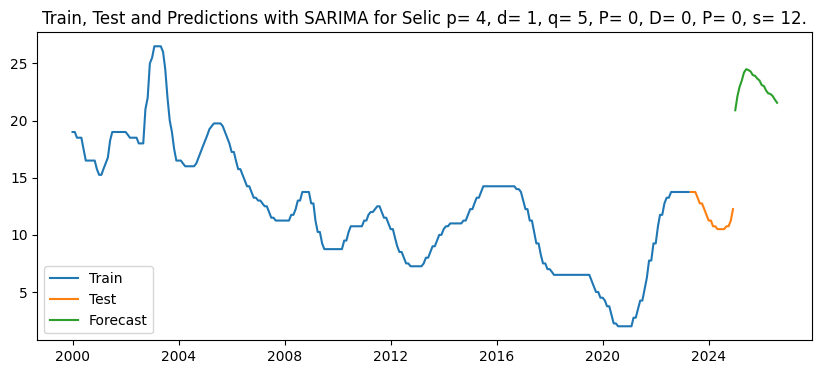

The MAE is 11.30
The RMSE is 11.41
The MAPE is 98.08 %


In [121]:
model_assessment(data2.selic.iloc[:-split], data2.selic.iloc[-split:],forecasts, "SARIMA for Selic p= 4, d= 1, q= 5, P= 0, D= 0, P= 0, s= 12.")

# ChatGPT Code

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                     SARIMAX Results                                                     
Dep. Variable:                                                             selic   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(10, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 12)   Log Likelihood                 -55.306
Date:                                                           Sun, 26 Jan 2025   AIC                            156.611
Time:                                                                   17:43:58   BIC                            228.048
Sample:                                                               01-01-2000   HQIC                           185.610
                                                                    - 12-01-2024                                         
Covariance Type:                                                             opg                                         
                 coef   

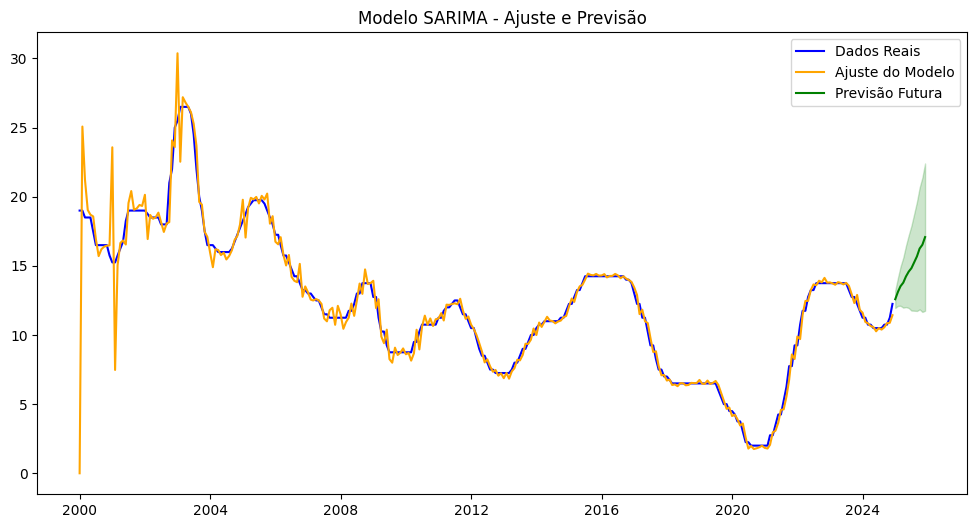

Erro Quadrático Médio (MSE): 2.20


In [59]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def aplicar_sarima(data, ordem=(1, 1, 1), ordem_sazonal=(1, 1, 1, 12), coluna_temporal=None, coluna_target=None, previsoes=12):
    """
    Aplica SARIMA a um conjunto de dados.

    :param data: DataFrame com os dados.
    :param ordem: Parâmetros p, d, q para o modelo SARIMA.
    :param ordem_sazonal: Parâmetros sazonais P, D, Q, S para o modelo SARIMA.
    :param coluna_temporal: Nome da coluna com datas (será usada como índice, se fornecida).
    :param coluna_target: Nome da coluna com valores de interesse (target).
    :param previsoes: Número de períodos futuros a serem previstos.
    :return: Modelo ajustado, previsões futuras, e gráfico do modelo.
    """
    # Configuração do índice temporal
    if coluna_temporal:
        data[coluna_temporal] = pd.to_datetime(data[coluna_temporal])
        data.set_index(coluna_temporal, inplace=True)

    if coluna_target:
        ts_data = data[coluna_target]
    else:
        ts_data = data

    # Ajuste do modelo SARIMA
    model = SARIMAX(ts_data, order=ordem, seasonal_order=ordem_sazonal, enforce_stationarity=False, enforce_invertibility=False)
    resultado = model.fit(disp=False)

    # Sumário do modelo
    print(resultado.summary())

    # Previsões in-sample
    previsao_in_sample = resultado.get_prediction(start=0, end=len(ts_data)-1)
    previsao_in_sample_mean = previsao_in_sample.predicted_mean

    # Previsões out-of-sample
    previsoes_futuras = resultado.get_forecast(steps=previsoes)
    previsao_out_sample_mean = previsoes_futuras.predicted_mean
    previsao_out_sample_conf = previsoes_futuras.conf_int()

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data, label='Dados Reais', color='blue')
    plt.plot(previsao_in_sample_mean, label='Ajuste do Modelo', color='orange')
    plt.plot(previsao_out_sample_mean, label='Previsão Futura', color='green')
    plt.fill_between(previsao_out_sample_conf.index,
                     previsao_out_sample_conf.iloc[:, 0],
                     previsao_out_sample_conf.iloc[:, 1], color='green', alpha=0.2)
    plt.title("Modelo SARIMA - Ajuste e Previsão")
    plt.legend()
    plt.show()

    # Métrica de avaliação
    mse = mean_squared_error(ts_data, previsao_in_sample_mean)
    print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

    return resultado, previsao_out_sample_mean

# Exemplo de uso

resultado, previsoes_futuras = aplicar_sarima(
    data=data2,  # Passar o DataFrame completo
    ordem=(1, 1, 1),
    ordem_sazonal=(10, 1, 10, 12),
    coluna_temporal=None,  # O índice já deve ser DatetimeIndex
    coluna_target='selic',  # Passar o nome da coluna como string
    previsoes=12
)

#Selic


In [130]:
model_selic = ARIMA(train['selic_Boxcox'], order=( 4, 1, 5),seasonal_order=(0, 0, 0, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


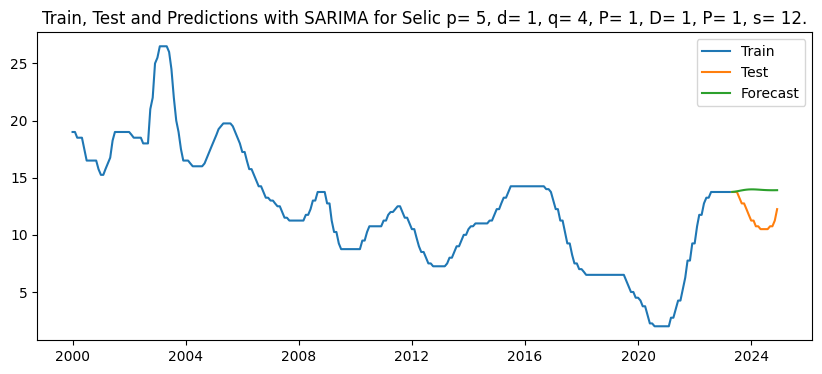

The MAE is 2.16
The RMSE is 2.48
The MAPE is 19.54 %


In [132]:
boxcox_forecasts = model_selic.forecast(len(test['selic_Boxcox']))
boxcox_forecasts.index = test['selic_Boxcox'].index
forecasts = inv_boxcox(boxcox_forecasts, lam_selic)

model_assessment(data2.selic.iloc[:-split], data2.selic.iloc[-split:],forecasts, "SARIMA for Selic p= 5, d= 1, q= 4, P= 1, D= 1, P= 1, s= 12.")

In [134]:
model_selic_forecast = ARIMA(data2['selic_Boxcox'], order=( 4, 1, 5),seasonal_order=(0, 0, 0, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


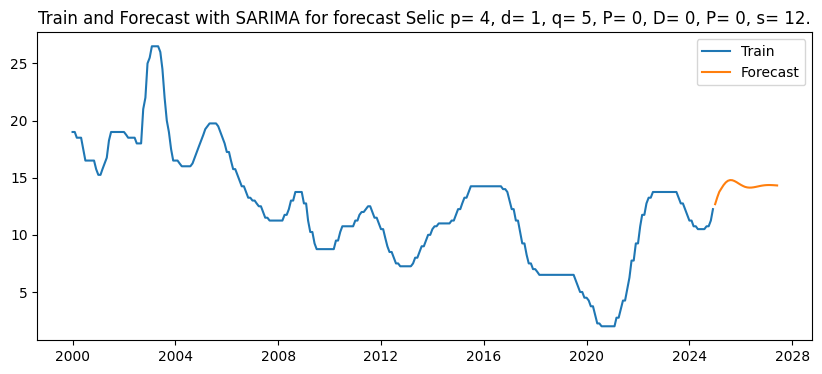

In [136]:
numero_de_previsoes = 30
boxcox_forecasts = model_selic_forecast.forecast(numero_de_previsoes)
forecasts = inv_boxcox(boxcox_forecasts, lam_selic)

plot_future(data2.selic, forecasts, "SARIMA for forecast Selic p= 4, d= 1, q= 5, P= 0, D= 0, P= 0, s= 12.")


#Ipca

In [77]:
model_ipca = ARIMA(train['ipca_Boxcox'], order=( 1, 1, 2),seasonal_order=( 1, 1, 1, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


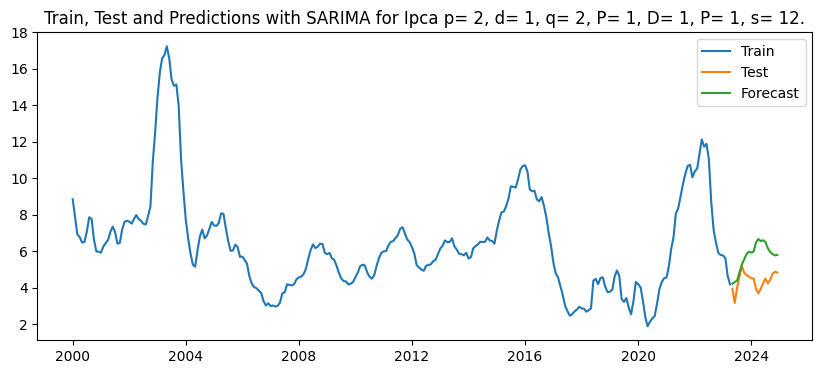

The MAE is 1.36
The RMSE is 1.59
The MAPE is 32.32 %


In [78]:
boxcox_forecasts = model_ipca.forecast(len(test['ipca_Boxcox']))
boxcox_forecasts.index = test['ipca_Boxcox'].index
forecasts = inv_boxcox(boxcox_forecasts, lam_ipca)

model_assessment(data2.ipca.iloc[:-split], data2.ipca.iloc[-split:],forecasts, "SARIMA for Ipca p= 2, d= 1, q= 2, P= 1, D= 1, P= 1, s= 12.")

In [139]:
model_ipca_forecast = ARIMA(data2['ipca_Boxcox'], order=( 2, 1, 2),seasonal_order=( 1, 1, 1, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

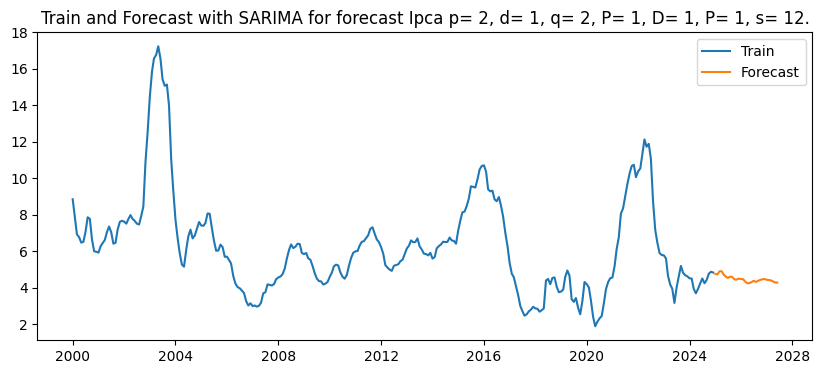

In [138]:
numero_de_previsoes = 30
boxcox_forecasts = model_ipca_forecast.forecast(numero_de_previsoes)
forecasts = inv_boxcox(boxcox_forecasts, lam_ipca)

plot_future(data2.ipca, forecasts, "SARIMA for forecast Ipca p= 2, d= 1, q= 2, P= 1, D= 1, P= 1, s= 12.")


#Dolar

In [52]:
model_dolar = ARIMA(train['dolar_Boxcox'], order=( 1, 1, 1),seasonal_order=( 1, 1, 1, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


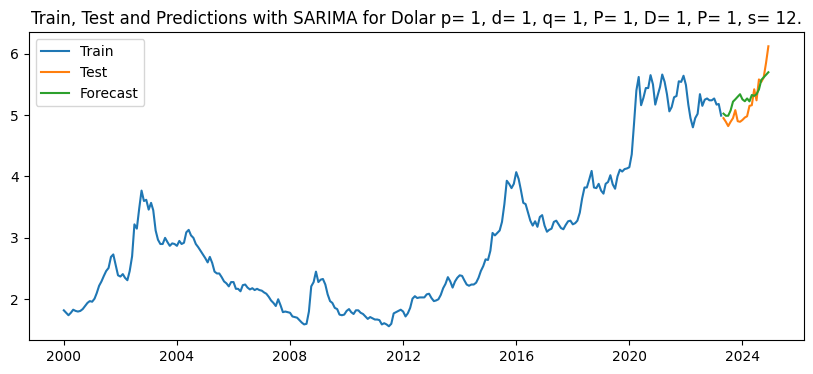

The MAE is 0.20
The RMSE is 0.24
The MAPE is 3.86 %


In [79]:
boxcox_forecasts = model_dolar.forecast(len(test['dolar_Boxcox']))
boxcox_forecasts.index = test['dolar_Boxcox'].index
forecasts = inv_boxcox(boxcox_forecasts, lam_dolar)

model_assessment(data2.dolar.iloc[:-split], data2.dolar.iloc[-split:],forecasts, "SARIMA for Dolar p= 1, d= 1, q= 1, P= 1, D= 1, P= 1, s= 12.")

In [142]:
model_dolar_forecast = ARIMA(data2['dolar_Boxcox'], order=( 1, 1, 1),seasonal_order=( 1, 1, 1, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


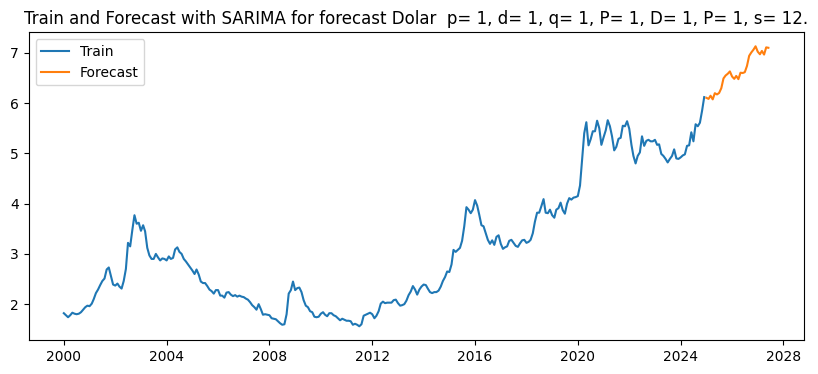

In [143]:
numero_de_previsoes = 30
boxcox_forecasts = model_dolar_forecast.forecast(numero_de_previsoes)
forecasts = inv_boxcox(boxcox_forecasts, lam_dolar)

plot_future(data2.dolar, forecasts, "SARIMA for forecast Dolar  p= 1, d= 1, q= 1, P= 1, D= 1, P= 1, s= 12.")

In [155]:
!jupyter nbconvert --to html /content/SELIC_IPCA_DOLAR.ipynb

[NbConvertApp] Converting notebook /content/SELIC_IPCA_DOLAR.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 41 image(s).
[NbConvertApp] Writing 3542657 bytes to /content/SELIC_IPCA_DOLAR.html
